# Image Super-Resolution Using Deep Convolutional Networks

This is the implementation of SRCNN.

More details can be found [here](http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html)

# Import original MNIST  and Lower-Resolution MNIST

In [1]:
from keras.datasets import mnist
from keras.layers import Reshape,Dense
import numpy as np
from keras.layers import UpSampling2D,MaxPool2D,Conv2D,Activation,Dropout,BatchNormalization
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy import ndimage as nd
import myplot
from skimage.measure import compare_psnr,compare_ssim
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator

def psnr(Original_test,test_image,interpolation):
    psnr_value = []
    for O_image,SR_image in zip(Original_test,test_image):
        imrecov = imresize(SR_image,size=(28,28),interp=interpolation)
        psnr_value.append(compare_psnr(O_image,imrecov.astype('float64')))
        return np.array(psnr_value).mean() 

Using TensorFlow backend.


In [2]:
mnist_data = mnist.load_data()
Original_image = mnist_data[0][0]
Original_test = mnist_data[1][0]
down=np.load('LR_mnist.npz')
LR_mnist=down['train_by2']

In [3]:
Original_image = np.reshape(Original_image,(Original_image.shape[0],Original_image.shape[1],Original_image.shape[2],1))
print 'shape of original image is %d x %d  x%d  x%d ' %Original_image.shape
LR_mnist = np.reshape(LR_mnist,(LR_mnist.shape[0],LR_mnist.shape[1],LR_mnist.shape[2],1))
print 'shape of downsample image is  %d x %d  x%d  x%d  ' %LR_mnist.shape 

shape of original image is 60000 x 28  x28  x1 
shape of downsample image is  60000 x 14  x14  x1  


# Traditional method of recover image from low resolution 

imresize support a lot of image Interpolation methods there I examed 5 of them. 
They are:  
- nearest 
- lanczors
- bilinear 
- cubic 
- bicubic 

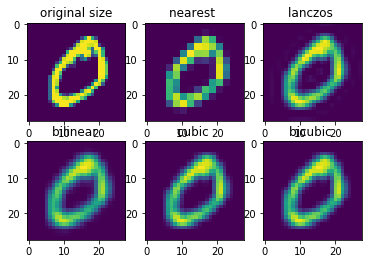

In [4]:
bicubic_mnist = np.reshape(LR_mnist,(LR_mnist.shape[0],LR_mnist.shape[1],LR_mnist.shape[2]))
temp_bicubic= []

for index in tqdm(range(len(bicubic_mnist))):
    temp_bicubic.append(imresize(bicubic_mnist[index],size=2.0,interp='bicubic'))
bicubic_mnist =np.array(temp_bicubic)
bicubic_mnist = np.reshape(bicubic_mnist,(bicubic_mnist.shape[0],bicubic_mnist.shape[1],bicubic_mnist.shape[2],1))

myplot.plot_comparison(Original_image[1][:,:,0],LR_mnist[1][:,:,0])

# The input is the bicubic-low-resolution image , the output is the original image

Before generate the model. It is very important to normalise the image . 

The original value of image is between 0 and 255, I will make it between -1 and 1. 


In [5]:
Original_image = (Original_image-127.5)/128
Original_test =(Original_test-127.5)/128
bicubic_mnist=(bicubic_mnist-127.5)/128

print 'Max of LR_mnist is %f, Min of LR_mnist is %f' %(LR_mnist.max() ,LR_mnist.min() )
print 'Max of Original_image is %f, Min of Original_image is %f' %(Original_image.max() ,Original_image.min() )


Max of LR_mnist is 255.000000, Min of LR_mnist is 0.000000
Max of Original_image is 0.996094, Min of Original_image is -0.996094


In [6]:
G=Sequential()
G.add(Conv2D(64,(9,9),padding='same',input_shape=(None,None,1)))
#G.add(Conv2D(16,(5,5),padding='same'))
#G.add(Dropout(0.9))
G.add(Activation('relu')) 
G.add(Conv2D(32,(1,1),padding='same'))
G.add(Activation('relu'))
# G.add(BatchNormalization())
G.add(Conv2D(1,(5,5),padding='same'))
#G.add(Activation('sigmoid'))
G.summary()

G.compile(loss='mse',optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 64)    5248      
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
activation_2 (Activation)    (None, None, None, 32)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 1)     801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [7]:
G.fit(x=bicubic_mnist,y=Original_image,batch_size=200,epochs=10)


Epoch 1/10
60000/60000 [==============================] - 19s - loss: 0.0438      

In [17]:
G.save('original_srcnn.h5')

# Benchmark 

In [8]:
test_image=down['test_by2'] 
temp_bicubic_test= []

for index in tqdm(range(len(test_image))):
    temp_bicubic_test.append(imresize(test_image[index],size=2.0,interp='bicubic'))
bicubic_mnist_test =np.array(temp_bicubic_test)
bicubic_mnist_test=(bicubic_mnist_test-127.5)/128
bicubic_mnist_test=np.reshape(bicubic_mnist_test,(bicubic_mnist_test.shape[0],bicubic_mnist_test.shape[1],bicubic_mnist_test.shape[2],1))


In [9]:
pred_img= G.predict(x=bicubic_mnist_test)
pred_img_3D = np.reshape(pred_img,(pred_img.shape[0],pred_img.shape[1],pred_img.shape[2]))

#pred_img_3D=(pred_img_3D*127.5)+127.5
'''
Original_test= (Original_test*127.5)+128
Original_test=Original_test.astype('uint8')
pred_img_3D =  pred_img_3D*127.5+128
pred_img_3D= pred_img_3D.astype('uint8')
'''

"\nOriginal_test= (Original_test*127.5)+128\nOriginal_test=Original_test.astype('uint8')\npred_img_3D =  pred_img_3D*127.5+128\npred_img_3D= pred_img_3D.astype('uint8')\n"

In [10]:
Original_test.max()

0.99609375

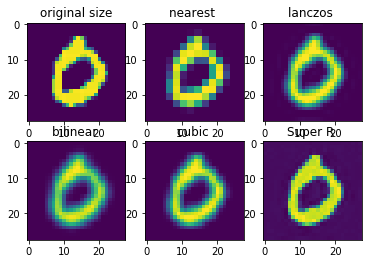

In [18]:
myplot.plot_3(Original_test[3],test_image[3],pred_img_3D[3])

In [12]:
compare_psnr(Original_test,pred_img_3D.astype('float64'))

27.681339123605085

In [13]:
psnr(Original_test,test_image,'bicubic')

-29.491212296237961

In [14]:
print '%f  %f  %f ' %(Original_test.max(),test_image.max(),pred_img_3D.max())

0.996094  255.000000  1.406377 
